# 1. Import Libraries

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import re

from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error

# 2. Import dataset

In [33]:
train_df = pd.read_csv('./dataset/train.csv') # as the data is huge (~1GB) data is not available in github. To run this, please download the dataset from Kaggle - https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data
train_df = train_df.drop(['sexual_explicit', 'identity_annotator_count', 'toxicity_annotator_count','created_date','publication_id','parent_id','article_id'], axis=1)
train_df.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,funny,wow,sad,likes,disagree
count,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,405130.000000,405130.000000,405130.000000,...,405130.000000,405130.000000,405130.000000,405130.000000,405130.00000,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06,1.804874e+06
mean,3.738434e+06,1.030173e-01,4.582099e-03,1.387721e-02,2.263571e-02,8.115273e-02,9.311271e-03,0.011964,0.003205,0.001884,...,0.001494,0.001356,0.012083,0.006724,0.05695,2.779269e-01,4.420696e-02,1.091173e-01,2.446167e+00,5.843688e-01
std,2.445187e+06,1.970757e-01,2.286128e-02,6.460419e-02,7.873156e-02,1.760657e-01,4.942218e-02,0.087166,0.050193,0.026077,...,0.015374,0.017505,0.089183,0.069027,0.21596,1.055313e+00,2.449359e-01,4.555363e-01,4.727924e+00,1.866589e+00
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.969752e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.223774e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,5.769854e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,9.090909e-02,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,0.750000,1.000000,1.000000,1.000000,1.00000,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 38 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [4]:
test_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1RcUx5dpbKuDxcXPrq3UVWuLSPOgs_Sjy")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97320 entries, 0 to 97319
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            97320 non-null  int64 
 1   comment_text  97320 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [5]:
test_df.head(5)

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...


In [6]:
train_df.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,physical_disability,psychiatric_or_mental_illness,transgender,white,rating,funny,wow,sad,likes,disagree
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,rejected,0,0,0,0,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,rejected,0,0,0,0,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,rejected,0,0,0,0,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,rejected,0,0,0,0,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,rejected,0,0,0,1,0


# 3. Exploratory Data Analysis

### 1. Target Feature

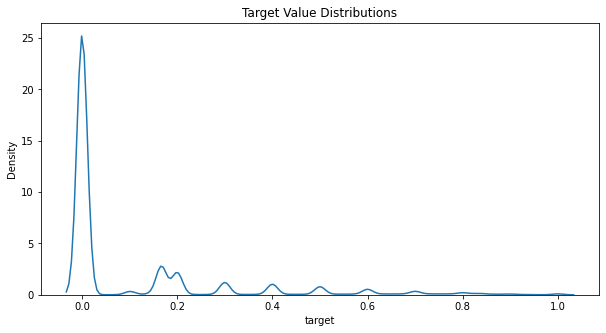

In [39]:
plt.figure(figsize=(10,5))
plt.title('Target Value Distributions')
sns.distplot(train_df['target'], hist=False, bins = 240, label = 'target')
plt.show();


### Most of the comments are non toxic

### 2. Additional toxicity, Gender, Race, Sexual orientation Features

In [50]:
def features_distribution_plot(features, title, data, ax):
    ax.set_title(title, fontsize=10)
    
    for feature in features:
        sns.distplot(data[feature],ax= ax, hist=False, bins=240, label=feature)
        
    ax.set(xlabel='title', ylabel='count')
    ax.legend(loc='upper right')


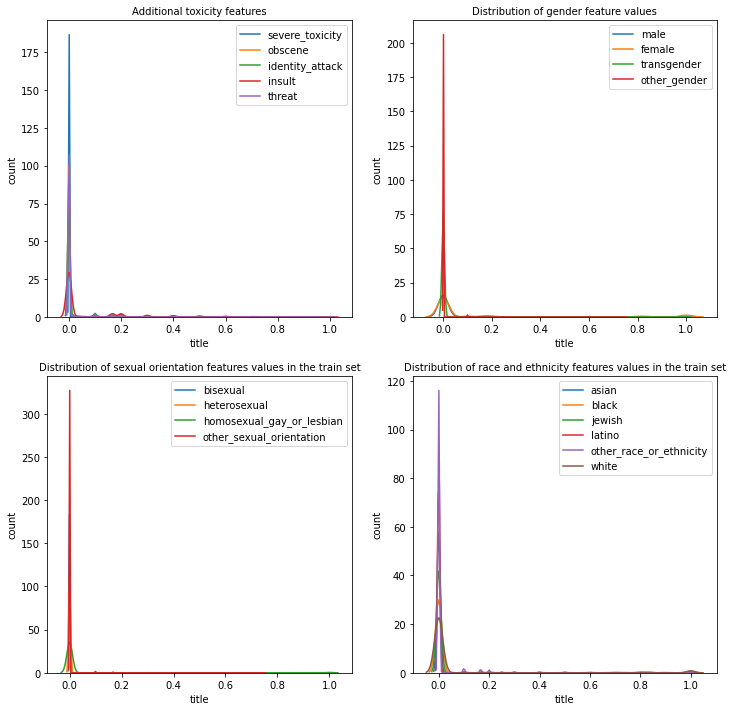

In [51]:
fig, ax = plt.subplots(2,2, figsize=(12,12))

# Plot addictional toxicity features' distribution
toxicity_features = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']
features_distribution_plot(toxicity_features, "Additional toxicity features", train_df, ax[0,0])

#Distribution of gender feature values
train_nan_removed = train_df.dropna(axis = 0, how = 'any')
gender_features = ['male', 'female', 'transgender', 'other_gender']
features_distribution_plot(gender_features, "Distribution of gender feature values", train_nan_removed, ax[0,1])

# Distribution of sexual orientation features values
sexual_orientation_features = ['bisexual', 'heterosexual', 'homosexual_gay_or_lesbian', 'other_sexual_orientation']
features_distribution_plot(sexual_orientation_features, "Distribution of sexual orientation features values in the train set", train_nan_removed, ax[1,0])

# Distribution of race and ethnicity features
race_features = ['asian', 'black', 'jewish', 'latino', 'other_race_or_ethnicity', 'white']
features_distribution_plot(race_features, "Distribution of race and ethnicity features values in the train set", train_nan_removed, ax[1,1])


### 3. Toxicity in racist, Sexist and Gender comments

In [12]:
def get_comment_nature(row):
    row = [row['severe_toxicity'], row['obscene'], row['identity_attack'], row['insult'], row['threat']]
    
    maxarg = np.argmax(np.array(row)) # Get the max value index.
    
    if maxarg == 0: return 'severe_toxicity'
    elif maxarg == 1: return 'obscene'
    elif maxarg == 2: return 'identity_attack'
    elif maxarg == 3: return 'insult'
    else: return 'threat'

In [13]:
def plot_perc_toxic_comments(x, axs, title):
    total = float(len(x))

    cntplot = sns.countplot(x,ax = axs)
    cntplot.set_title(title, fontsize = 15)

    # Get the height and calculate percentage then display it the plot itself.
    for p in axs.patches:
        height = p.get_height()
        axs.text(p.get_x() + p.get_width()/2.0, height + 3, '{:1.2f}%'.format(100*height/total), ha='center')


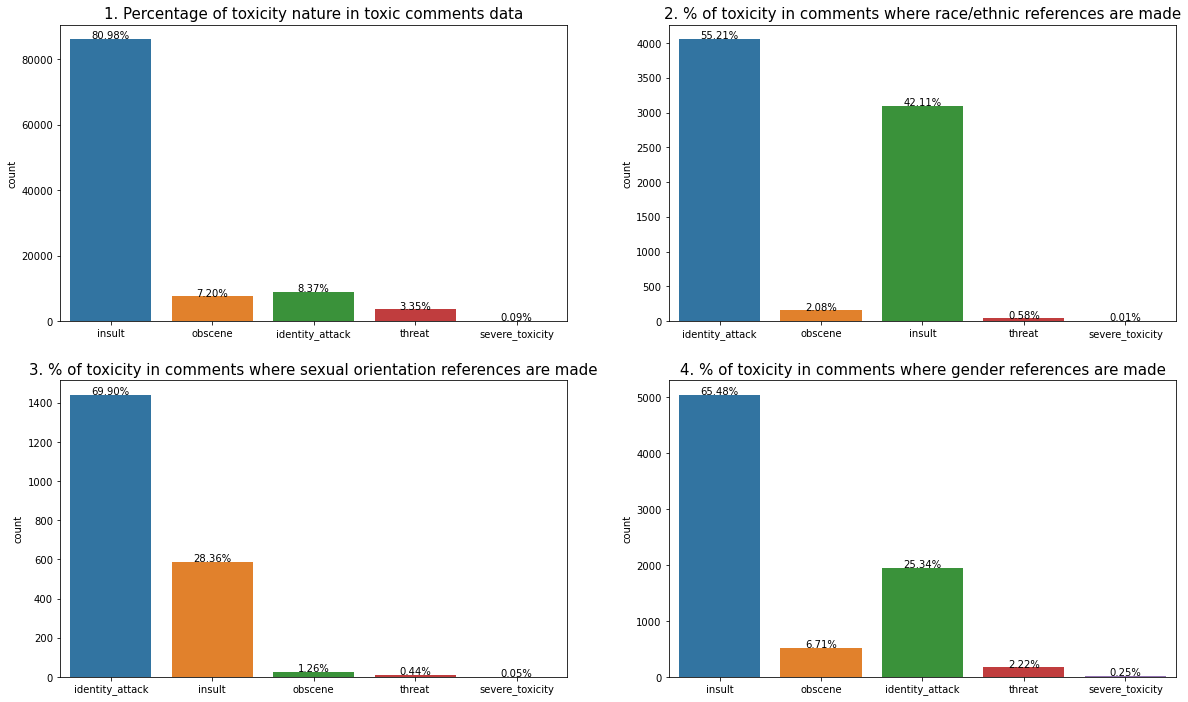

In [54]:
fig, ax = plt.subplots(2,2, figsize=(20,12))

# Percentage of toxicity nature in toxic comments data
x = train_df[train_df['target']>0.5].apply(get_comment_nature, axis=1) 
plot_perc_toxic_comments(x, ax[0,0], '1. Percentage of toxicity nature in toxic comments data')

# Percentage of type of toxicity in comments where race/ethnic references are made
condition_race = (train_df['asian'] > 0.5) | (train_df['black'] > 0.5) | (train_df['jewish'] > 0.5) | (train_df['latino'] > 0.5) | (train_df['white'] > 0.5)
race_trian = train_df[condition_race]
race_trian = race_trian[race_trian['target'] > 0.5] 

racist_comments = race_trian.apply(get_comment_nature, axis=1)
plot_perc_toxic_comments(racist_comments, ax[0,1], '2. % of toxicity in comments where race/ethnic references are made')

# Percentage of type of toxicity in comments where sexual orientation references are made'
sexual_orientation_condition = (train_df['bisexual'] > 0.5) | (train_df['heterosexual'] > 0.5) | (train_df['homosexual_gay_or_lesbian'] > 0.5) | (train_df['other_sexual_orientation'] > 0.5) 
sexual_orient_train = train_df[sexual_orientation_condition]
sexual_orient_train = sexual_orient_train[sexual_orient_train['target'] > 0.5]

sexist_comments = sexual_orient_train.apply(get_comment_nature, axis=1) 
plot_perc_toxic_comments(sexist_comments, ax[1,0], '3. % of toxicity in comments where sexual orientation references are made')

# Percentage of type of toxicity in comments where gender references are made
gender_conditiom = (train_df['male'] > 0.5) | (train_df['female'] > 0.5) | (train_df['transgender'] > 0.5) | (train_df['other_gender'] > 0.5) 
gender_train = train_df[gender_conditiom]
gender_train = gender_train[gender_train['target'] > 0.5] 

gender_comments = gender_train.apply(get_comment_nature, axis=1)
plot_perc_toxic_comments(gender_comments, ax[1,1], '4. % of toxicity in comments where gender references are made')


### Derived conclusions:

##### 1. Percentage of toxicity in toxic comments data - most of the toxic comments are insults

##### 2. % of type of toxicity where race/ethnic references are made - most of the race/ethnic comments are identity_attacks and insults

##### 3. % of type of toxicity in comments where sexual orientation references are made - most of them are identity_attacks and insults

##### 4. % of type of toxicity in comments where gender references are made - most are insults and identity attacks

### 4. Users Feedback Featuers

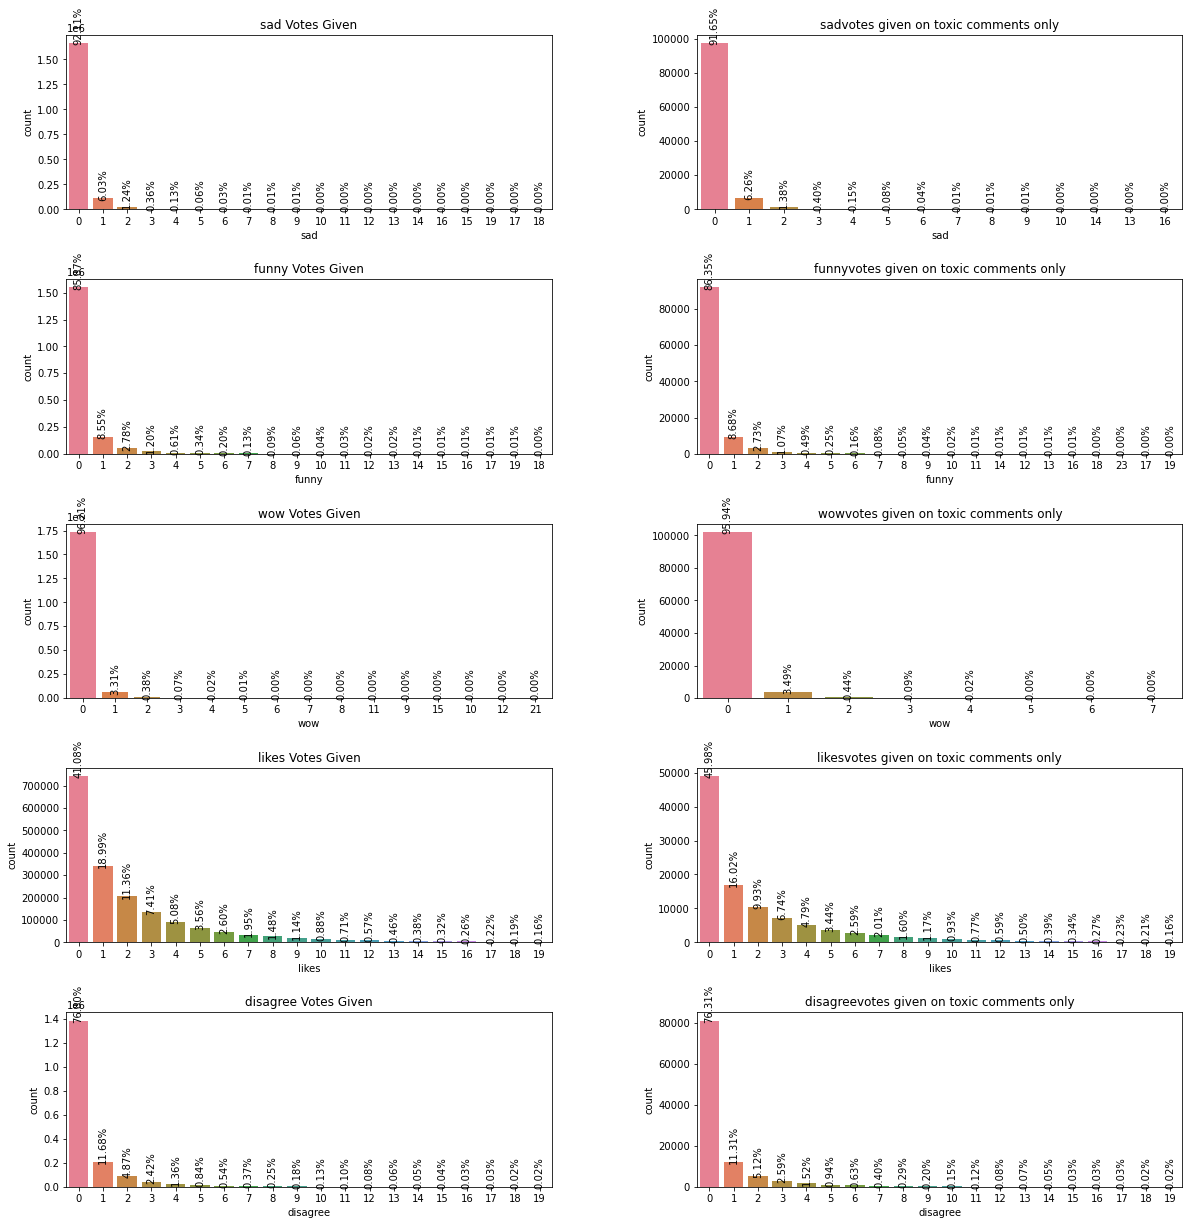

In [58]:
def plot_count(feature, title, data, axs, size = 1):
    total = float(len(data))
    
    cntplt = sns.countplot(data[feature], ax = axs, order = data[feature].value_counts().index[:20], palette = 'husl')
    cntplt.set_title(title)
    
    for p in axs.patches:
        axs.text(p.get_x() + p.get_width()/2., p.get_height() + 3, '{:1.2f}%'.format(100 * p.get_height()/total), ha="center", rotation="vertical")    
    
    plt.subplots_adjust(bottom=0.1,top=0.9, wspace=0.3, hspace=0.4)
    
f, ax = plt.subplots(5,2, figsize=(20,20))
for i, l in enumerate(['sad', 'funny', 'wow', 'likes','disagree']):
    plot_count(l, l + ' Votes Given', train_df, ax[i,0], 3)
    plot_count(l, l + 'votes given on toxic comments only', train_df[train_df['target'] > 0.5], ax[i,1], 3)


### 5. Comments Features

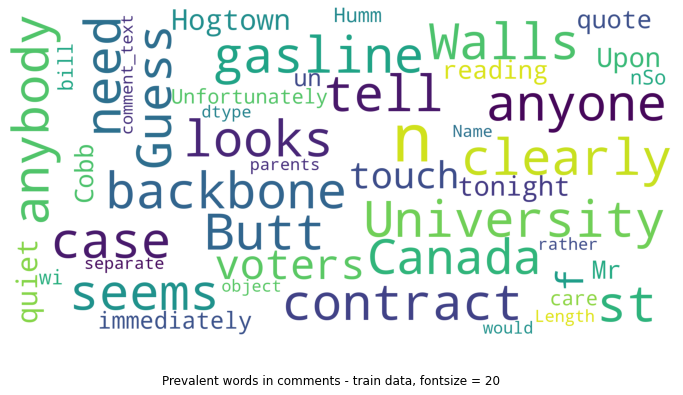

In [59]:
stopWords = stopwords.words('english')

wordcloud = WordCloud(background_color = 'white', stopwords = set(stopWords), max_words = 60, max_font_size = 40, scale = 5).generate(str(train_df['comment_text'].sample(20000)))

fig = plt.figure(1, figsize=(12,12))
plt.axis('off')
fig.suptitle('Prevalent words in comments - train data, fontsize = 20')
fig.subplots_adjust(top=2.3)
    
plt.imshow(wordcloud)
plt.show()
    

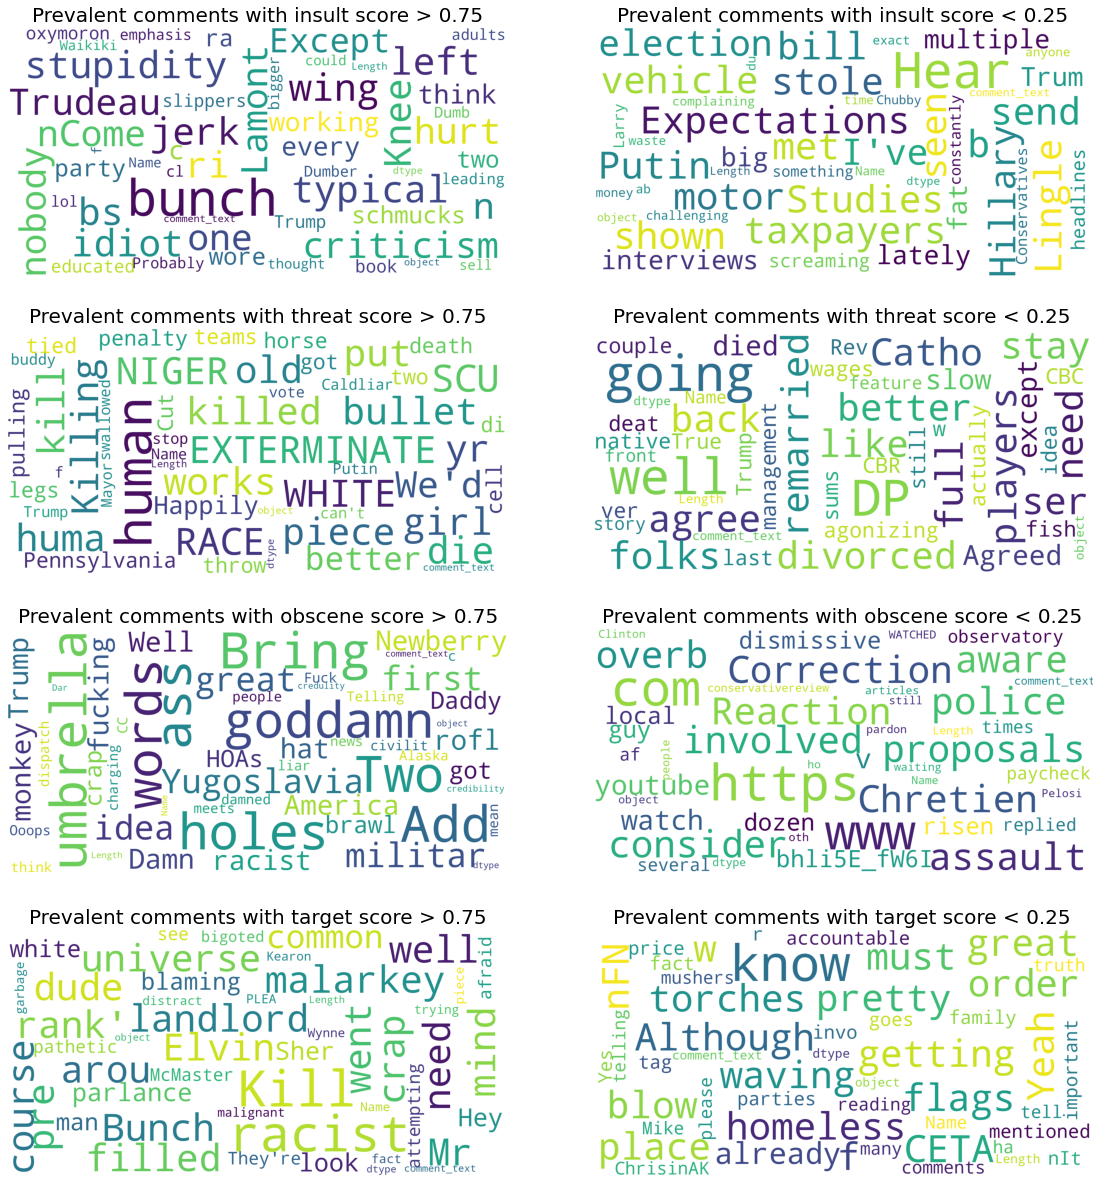

In [60]:
# define a function to create a wordcloud
def word_cloud(data, title, ax, fig):
    wordcloud = WordCloud(background_color = 'white', stopwords = set(stopWords), max_words = 60, max_font_size = 40, scale = 5).generate(str(data))
    ax.axis('off')
    ax.set_title(title, fontsize = 20)
    fig.subplots_adjust(bottom=0.1,top=0.9, wspace=0.1, hspace=0.2)
    ax.imshow(wordcloud)

fig, ax = plt.subplots(4,2, figsize=(20,20))

# show the words in different toxicity categories
for i,l in enumerate(['insult', 'threat', 'obscene', 'target']):
    word_cloud(train_df.loc[train_df[l] > 0.75]['comment_text'].sample(200), 'Prevalent comments with ' + l + ' score > 0.75', ax[i,0], fig)
    word_cloud(train_df.loc[train_df[l] < 0.25]['comment_text'].sample(200), 'Prevalent comments with ' + l + ' score < 0.25', ax[i,1], fig)


# 4. Data Preprocessing and train-test split

In [19]:
def text_process(comments):
    corpus = []
    ps = PorterStemmer()
    
    for comment in comments:
        comment = comment.lower()
        listComment = comment.split()
        listComment = [re.sub('[^a-zA-Z]', '', ps.stem(word.strip())) for word in listComment  if word.strip() not in stopWords]
        
        comment = ' '.join(listComment)
        corpus.append(comment)
        
    print(len(corpus))
    return corpus
    
    
corpus = text_process(train_df['comment_text'])


1804874


In [20]:
corpus[0]

'cool like would want mother read this realli great idea well done'

In [21]:
corpus_test = text_process(test_df['comment_text'])

97320


In [22]:
X_train, X_test, y_train, y_test = train_test_split(corpus, train_df['target'], test_size=0.3 )


# 5. Bag of Words Model

In [23]:
cVector = CountVectorizer(max_features = 30000)
cv_train = cVector.fit_transform(X_train)
cv_test = cVector.fit_transform(X_test)


In [24]:
y_train

968005     0.000000
15070      0.000000
531660     0.000000
536304     0.166667
1669906    0.000000
             ...   
432534     0.000000
293482     0.871429
640228     0.000000
1311298    0.700000
1486946    0.200000
Name: target, Length: 1263411, dtype: float64

# 6. Train the Model

In [25]:
dt_regressor = DecisionTreeRegressor(max_depth = 5, min_samples_leaf = 100)
dt_regressor.fit(cv_train, y_train)


DecisionTreeRegressor(max_depth=5, min_samples_leaf=100)

# 7. Test the model

In [26]:
y_predict = dt_regressor.predict(cv_test)

In [27]:
err = mean_squared_error(y_test, y_predict)
print(err)

0.038822823233797946


# 8. Test on testset

In [28]:
cv_test_df = cVector.fit_transform(test_df['comment_text'])
y_predict_ = dt_regressor.predict(cv_test_df)


In [29]:
print(y_predict_)

[0.08904309 0.08904309 0.08904309 ... 0.08904309 0.08904309 0.08904309]


In [30]:
indices = np.where(y_predict_>0.7)
indices

(array([  299,  1117,  1195,  1332,  3178,  4257,  4314,  4499,  5100,
         5561,  6068,  7576,  7649,  8669, 11356, 11482, 11967, 12503,
        12796, 12925, 13002, 15191, 17018, 17118, 17142, 17176, 17979,
        18224, 18461, 18866, 20257, 20331, 20537, 21041, 21197, 21359,
        21410, 22037, 23668, 23691, 24154, 24863, 26590, 27150, 27171,
        27457, 27841, 27983, 28903, 30403, 30867, 31131, 31176, 31261,
        32053, 32073, 33825, 35568, 35637, 35744, 36212, 36579, 36917,
        37184, 37973, 38668, 39354, 39993, 41303, 41773, 42400, 43474,
        43798, 44190, 44304, 45699, 46174, 47875, 48178, 48372, 48888,
        49177, 49253, 50201, 50774, 51898, 54118, 54187, 54664, 54735,
        55590, 55843, 56031, 61046, 61658, 62913, 65189, 65609, 66410,
        67178, 68056, 68087, 68549, 68822, 68872, 70882, 70923, 72587,
        72689, 72694, 73067, 74011, 74039, 74089, 74096, 74590, 75470,
        76488, 76627, 76662, 77132, 77788, 78644, 79149, 80320, 81215,
      

In [31]:
print(test_df["comment_text"].iloc[269] + " - toxicity level: " + str(y_predict_[269]) + "\n")
print(test_df["comment_text"].iloc[95558] + " - toxicity level: " + str(y_predict_[95558]) + "\n")


Typical Repube answer xbt! Isn't it awfully strange how every single one that's either resigning or quitting or getting fired just happens to be a Repube??? Hmmmmm what are the odds of that??? - toxicity level: 0.08904308625136682

Hmmmmm.....New liberal mayor
Hmmmmm.....Inexperienced political appointee as Chief of Police
Hmmmmm.....Massive increase in murder and crime in Anchorage. - toxicity level: 0.08904308625136682



# Cheers!